In [14]:
#!pip install hazm
# !pip install tensorflow-gpu==2.0.0
# !pip install tensorflow

In [12]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot
from hazm import *

from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')


2024-03-03 19:53:53.492168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [95]:
df = pd.read_csv('data_train.csv', encoding="utf-8")

In [96]:
df.head(3)

,id,comment,intent
0,14311999,خوب وخوش طعم بود,"1,5"
1,14312094,واقعا دست مریزاد هراز جان هم زده پروبیوتیک و خ...,"1,5"
2,14312102,هنوز استفاده نکردم ولی عطر خوبی داره بسته بندی...,"1,5"


In [97]:
df.tail(3)

,id,comment,intent
89997,15336949,خوب و معمولی است.,1
89998,15336950,بد نیست,1
89999,15336955,نسبتا خوب,1


In [98]:
df['intent'].value_counts()

intent
1,5    10000
1,4    10000
1,3    10000
1,2    10000
5      10000
4      10000
3      10000
2      10000
1      10000
Name: count, dtype: int64

<Axes: xlabel='intent'>

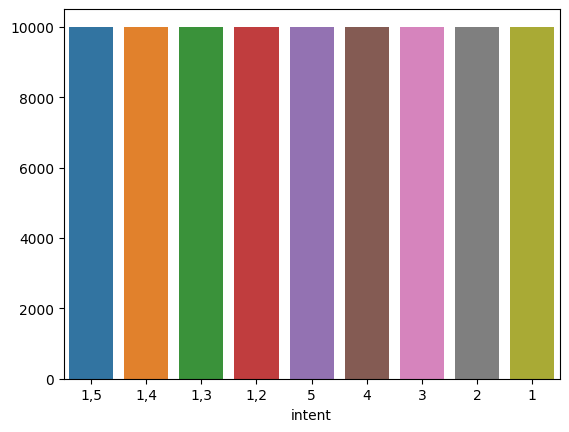

In [99]:
sns.barplot(x=df['intent'].value_counts().index, y=df['intent'].value_counts().values)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       90000 non-null  int64 
 1   comment  90000 non-null  object
 2   intent   90000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.1+ MB


In [101]:
df['intent'] = df['intent'].str.replace('1,2', '6').replace('1,3', '7').replace('1,4', '8').replace('1,5', '9').astype('int')

In [107]:
np.unique(label_train)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [102]:
sentence_train = df['comment']
label_train = df['intent']

print('Number of training sentence: ', sentence_train.shape)
print('Number of training label: ', label_train.shape)

Number of training sentence:  (90000,)
Number of training label:  (90000,)


In [103]:
from collections import Counter
cnt = Counter(label_train)
cnt = dict(cnt)
print(cnt)

{9: 10000, 8: 10000, 7: 10000, 6: 10000, 5: 10000, 4: 10000, 3: 10000, 2: 10000, 1: 10000}


In [104]:
# Convert dataframes to numpy arrays
sentence_train = np.asarray(sentence_train)
label_train = np.asarray(label_train)

In [106]:
# Prepare labels for categorical prediction
categorical_label_train = to_categorical(label_train, 10)
categorical_label_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## Preprocessing

In [108]:
import re
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stemmer = Stemmer()
# turn a doc into clean tokens
def clean_data(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    # ['یه', 'ساله', 'خریدم', 'خیلی', 'ضعیف', 'است', 'بازی', 'هم', 'که', 'چی', 'بگم', 'هیچ', 'کدوم', 'رو', 'باز', 'نمیکنه']
    tokens = []
    for token in tokenized:
      token = re.sub("[،:.,;()/+]", " ", token) 
      token = re.sub(r"\!+","!", token)
      token = re.sub(r"\؟+","؟", token)
      token = re.sub(r"\u200c", " ", token)
      tokens.append(token)

    tokens = [w for w in tokens if not len(w) <= 1] # single character removal 
    tokens = [w for w in tokens if not w.isdigit()] # digit remove
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = [stemmer.stem(w) for w in tokens] 
    tokens = ' '.join(tokens)
    return tokens

## Apply preprocessing to dataset

In [112]:
train_docs = np.empty_like(sentence_train)
for index, document in enumerate(sentence_train):
  train_docs[index] = clean_data(document)

## Set tokenizer and encode sentences

In [114]:
num_words = 2000

# Create the tokenizer
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_docs)
encoded_docs = tokenizer.texts_to_sequences(train_docs)
print(encoded_docs[:10])

[[6, 1101, 47, 2, 1], [62, 460, 393, 15, 361, 52, 477, 1222], [255, 51, 13, 9, 11, 133, 6, 17, 81, 111, 78, 38, 15, 17, 61, 4, 321, 396, 7, 51, 13, 9], [168, 3, 6, 17, 45, 32, 1821, 68], [8, 3, 1494, 7, 1289, 646, 1210, 51, 16, 9, 11, 20, 202, 19, 1684, 51, 13, 9, 7, 3, 160, 217], [23, 3, 6, 32, 6, 3, 258, 748, 16, 453, 183, 15, 19, 218, 472, 16, 385], [205, 32, 18, 11, 119, 274, 32, 527, 268, 40, 502, 44, 99, 89, 9], [3, 37, 52, 2, 1, 46, 8, 97, 7, 101, 1102, 795, 5, 211, 72, 2, 1, 1128, 97, 2, 1, 163, 157, 170, 121, 515, 1598, 355, 1685, 10, 905, 69, 680, 8, 16, 33], [47, 18, 99, 16, 9], [72, 120, 3, 103, 17]]


In [115]:
# Find maximum length of training sentences
max_length = max([len(s.split()) for s in train_docs])
max_length    

603

## Padding

In [117]:
# Pad embeded training sequences
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [119]:
#vocabulary size
vocab_size = len(tokenizer.word_index)

In [122]:
model_blstm = Sequential()

model_blstm.add(Embedding(vocab_size, 300, input_length=max_length))
model_blstm.add(Bidirectional(LSTM(300, return_sequences=True, name='lstm_layer')))

model_blstm.add(GlobalMaxPool1D())
model_blstm.add(Dropout(0.25))
model_blstm.add(Dense(300, activation="relu"))
model_blstm.add(Dropout(0.2))
model_blstm.add(Dense(5, activation='softmax'))

In [123]:
model_blstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["categorical_accuracy"])

model_blstm.summary()
batch_size_blstm = 64
epochs_blstm = 12     

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 603, 300)          7267200   
                                                                 
 bidirectional_1 (Bidirecti  (None, 603, 600)          1442400   
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 600)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_2 (Dropout)         (None, 600)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               180300    
                                                                 
 dropout_3 (Dropout)         (None, 300)              

In [124]:
hist_blstm = model_blstm.fit(x_train_padded, categorical_label_train,
                             batch_size=batch_size_blstm, epochs=epochs_blstm,
                             shuffle=True)

Epoch 1/12


ValueError: in user code:

    File "/Users/andishetavakkoli/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/andishetavakkoli/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/andishetavakkoli/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/andishetavakkoli/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/andishetavakkoli/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/Users/andishetavakkoli/miniconda3/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/andishetavakkoli/miniconda3/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/andishetavakkoli/miniconda3/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/andishetavakkoli/miniconda3/lib/python3.11/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/andishetavakkoli/miniconda3/lib/python3.11/site-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 10) and (None, 5) are incompatible
